## Guide: Defining a custom loss function

`SynthEvo` supports the definition of custom loss functions, which can be used to guide the search towards a specific goal beyond Near-Perfect Adaptation and Ultrasensitivity.

We can define a custom loss function taking inspiration from one of the presets, for example the 
adaptation loss:


```julia
function adaptation_loss(C, norm, target, t0, t1)
    """
    Compute the error of the adaptation. 
    This is the difference of the change in the target species at the two fix points.

    > parameters: X_0, X_1 state at t0 and t1

    Args:
    - `norm`: the norm to use

    Returns:
    - expression/variables pair
    """
    @parameters X_0[1:C.N + length(C.control)] X_1[1:C.N + length(C.control)]
    if norm == 1
        expression = abs(X_1[target] - X_0[target])
    else
        expression = (X_1[target] - X_0[target])^norm
    end
    parameters = [X_0, X_1]
    variables = [on_species(C, X_0), on_species(C, X_1)]
    times = [t0, t1]
    return loss_wrapper(expression, parameters, variables, times)
end
```

As you can see there are some convention to follow and for values to be specified. Fisrt we define
the parameters of the loss function, they express the symbolic components of this function. We assume 
that such values represnt either a state at a certain time of the system/control variables or the 
parameters of the network itself (for example, the reaction rates). We distinguish between `parameters` and  `variable` to express the difference between symbols necessary for the evaluation of the loss functions and the ones for which we require the gradient. The `times` array is used to specify the time at which the state is evaluated. Naming convention on the parametes can be followed to imporve the 
efficiency while taking the derivatives, reducing the number of differentiation necessary when combining multiple losses.

> Currently we don't support loss functions with trainable parameters, but this is a relatively simple extension. Additionally we plan on supporting continuos time loss functions as well.

Let's define a custom loss function that enforces a target species to a setpoint after a perturbation:

In [7]:
using SynthEvo, Catalyst, Plots

function setpoint_loss(C, norm, target, t1, setpoint)
    """
    Evaluate the distance of a target species to a setpoint.

    > parameters: X_1 state at t1

    Args:
    - `norm`: the norm to use

    Returns:
    - expression/variables pair
    """
    @parameters X_1[1:C.N + length(C.control)]
    if norm == 1
        expression = abs(X_1[target] - setpoint)
    else
        expression = (X_1[target] - setpoint)^norm
    end
    # required inputs for the computing the loss function
    parameters = [X_1]
    # we don't want to derive wrt the control input
    variables = [on_species(C, X_1)]
    times = [t1]
    # the loss_wrapper precomputes the computational graph for efficiency
    return loss_wrapper(expression, parameters, variables, times)
end

# create a CRN
C = make_FullyConnectedNonExplosive_CRN(3)

# we can see 
setpoint_l = setpoint_loss(C, 2, 3, 20., 0.5)
setpoint_l.expr

(-0.5 + X_1[3])^2

we can immediately test it by calling the `symbolic_gradient_descent` function with the new loss function:

In [14]:
gd_options_plot_sp = (
    n_iter = 100,
    verbose = true,
    use_random_perturbation = false,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    fraction_gradient_noise = 0.01,
    alpha = 0.1,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)

gd_perturbation_options_plot_sp = (
    t0 = 10,
    t1 = 20,
    loss_fun = setpoint_l,
    input = 1,
    perturbation_list = [2]
)

sp_results = SynthEvo.symbolic_gradient_descent([1 for _ in 1:length(C.parameters)], C, gd_options_plot_sp, gd_perturbation_options_plot_sp, nothing)

nothing

And plot the results:

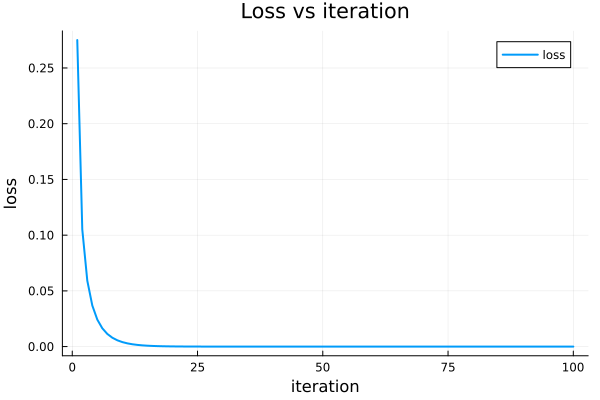

In [15]:
symGD_plot_loss(sp_results)

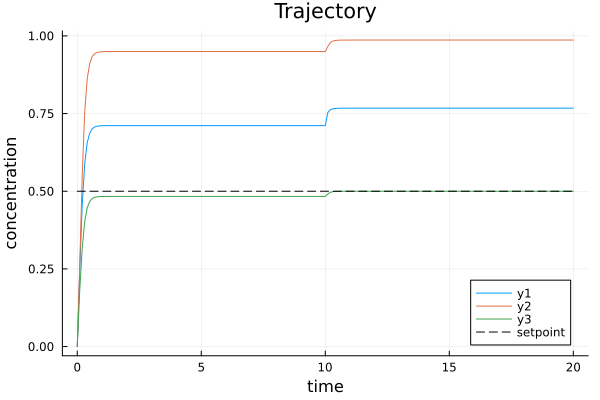

In [18]:
quick_trajectory_plot(C, sp_results.parameter_tape[argmin(sp_results.loss_tape)], 1, gd_perturbation_options_plot_sp.perturbation_list, gd_perturbation_options_plot_sp.t0, gd_perturbation_options_plot_sp.t1, 3)
plot!([0,gd_perturbation_options_plot_sp.t1], [0.5, 0.5], color=:black, linestyle=:dash, label="setpoint", legend=:bottomright)

We provide the `weighted_loss` function, which can be used to combine multiple loss functions with different weights.